<a href="https://colab.research.google.com/github/YanaStekolshchikova/da_course/blob/main/%D0%B4%D0%B7_2_sk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Устанавка библиотек
`! pip install` - это команда позволит нам установить нужные библиотеки.  
В данном случае, `ipython-sql`,  `prettytable` нужны чтобы легко могли писать `sql` запросы, без каких либо оберток

In [3]:
! pip install ipython-sql prettytable==0.7.2

# Включение магической функции `sql`

In [4]:
%load_ext sql
%reload_ext sql

# Подключение к БД
Будем работать с диалектом `SQLite`, `SQLite` -  компактная встраиваемая СУБД, для него не стоить отдельный сервер поднимать, поэтому к нему проще всего подключиться)  
Ниже в картинке указана база данных `Northwind`, представляет простую схему для управления клиентами малого бизнеса, заказами, запасами, закупками, поставщиками, доставкой и сотрудниками  
Что стоит обратить в схеме
* Название таблицы (`Orders`, `Customers`, и так далее)
* Ключ таблицы (`OrderId`, `CustomerId`), заметьте, в некоторых таблицах (`OrderDetails`), 2 основных ключа (`OrderId`, `ProductId`), это значит что запись уникальная по этим колонкам. Примере, в заказе `OrderId` может быть несколько продуктов `ProductId`
* Каждой колонке указан тип данных, пример `nvarchar(20)` означает, что колонка содержит строке не длиннее 20 символов
* Также есть тип колонки `Nullable`, он означает что в записи данная колонка может иметь значение или может не иметь

Типичные диаграммы называют - ERD диаграммой, https://www.lucidchart.com/pages/ru/erd-diagram

![База данных](Northwind_ERD.png)

In [5]:
%sql sqlite:///northwind.db
%config SqlMagic.style = 'DEFAULT'

# Полезные ссылки, которые помогут решить ДЗ
Тут все про синтаксис работы `SQLite` - https://www.sqlitetutorial.net/sqlite-functions/
Что понадобится в ДЗ?
* `SELECT`, `FROM` - база
* `LIMIT` - выводит определенное кол-во строк
* `DISTINCT` - выводит уникальные строки по полю
* `ORDER BY` - сортирует строки
* `WHERE` - фильтрация строк
* `GROUP BY`
* `AS` - нужно чтобы переименовать колонку/таблицу
* `MIN`, `MAX`, `SUM`, `AVG`, `COUNT` - группировки (мин, макс, сумма, среднее, кол-во)
* `ROUND(number, 2)` - округляет кол-во цифр после запятой
* `DATE(date_column, 'start of month')` - приводит дату `2024-01-05` к первому дня месяца `2024-01-01`
* `DATE(date_column, 'start of year')` - приводит дату `2024-01-05` к первому дня года `2024-01-01`
* `CAST(column AS INT)` - приводит колонку к какому то типу
* `INNER JOIN` `LEFT JOINT` - нужно чтобы соединить по какому то правилу две таблицы
* `WITH`, `DROP TABLE IF EXISTS`, `CREATE TABLE` - нужно чтобы создавать временные таблички
* `CASE WHEN`
* `ROW_NUMBER, LAG` - примеры оконных функций
*  `ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW` - чаще всего в оконках используется, делает какую то функцию оконки, до текущей строки

# Задача 0
Нужно вывести топ 5 городов пользователей, которые совершили заказы в 2016 году

In [6]:
%%sql
-- здесь код
SELECT
    DATE(orders.orderDate, 'start of year') AS order_year, -- можно было без этого, но просто хотел показать как работает функция
    customers.city                          AS city,  -- города пользователей
    COUNT(*)                                AS cnt, -- кол-во заказов
    COUNT(DISTINCT orders.customerID)       AS distinct_customer -- кол-во уникальных пользователей
FROM orders
    INNER JOIN customers
        ON customers.customerId = orders.customerId
WHERE orderDate >= '2016-01-01' AND orderDate < '2017-01-01' -- фильтруем даты (2016 год), '2016-01-01' автоматически переведется в тип DATE
GROUP BY 1, 2-- это говорит о том что, нужно группировать по 1, 2 колонке
ORDER BY 3 DESC -- это говорит о том что, нужно сортировать по 3 колонке
LIMIT 5 -- выводим 5 записей

 * sqlite:///northwind.db
Done.


order_year,city,cnt,distinct_customer
2016-01-01,London,89,6
2016-01-01,México D.F.,86,5
2016-01-01,Sao Paulo,65,4
2016-01-01,Madrid,56,3
2016-01-01,Rio de Janeiro,53,3


In [8]:
%%sql
-- здесь код
DROP TABLE IF EXISTS orderStatus; -- сбрасываем табличку если она есть
CREATE TABLE orderStatus AS -- создаем временную табличку в бд
    SELECT
        orderId,
        customerId,
        orderDate,
        CASE -- если заказ раньше 2013 года то Old иначе New
            WHEN orderDate < '2013-01-01' THEN 'Old'
            ELSE 'New'
        END AS orderStatus,
    ROW_NUMBER() OVER ( -- пронумировываем строки
        PARTITION BY customerId,  -- по каждому клиенту нумерация начнется
            CASE WHEN orderDate < '2013-01-01' THEN 'Old' ELSE 'New' END -- сортируем клиента по типу заказа новое/старое
        ORDER BY orderDate  -- нумерация по возрастнию даты заказа
    ) AS orderRank
FROM orders;

WITH customerAggregates AS ( -- временная табличка которая живет только в рамках запроса
  SELECT
    customerId,
    COUNT(*) AS totalOrders,
    SUM(CASE WHEN OrderStatus = 'Old' THEN 1 ELSE 0 END) AS oldOrders,
    SUM(CASE WHEN OrderStatus = 'New' THEN 1 ELSE 0 END) AS newOrders,
    ROUND(CAST(SUM(CASE WHEN OrderStatus = 'New' THEN 1 ELSE 0 END) AS REAL)
          / COUNT(*) * 100, 2) AS newOrderPercentage
  FROM (SELECT * FROM orderStatus) AS o -- подзапрос, я его просто написал чтобы увидели разницу
  GROUP BY 1
)
SELECT
  o.CustomerID,
  o.OrderID,
  o.OrderDate,
  o.OrderStatus,
  o.OrderRank,
  a.TotalOrders,
  a.OldOrders,
  a.NewOrders,
  a.NewOrderPercentage
FROM orderStatus AS o
    INNER JOIN customerAggregates AS a
        ON o.customerId = a.customerId

UNION ALL -- здесь конкатериуем две таблицы с запросами

-- Сводная строка для каждого клиента
SELECT
  CustomerID,
  NULL AS OrderID,
  NULL AS OrderDate,
  'Summary' AS OrderStatus,
  NULL AS OrderRank,
  TotalOrders,
  OldOrders,
  NewOrders,
  NewOrderPercentage
FROM customerAggregates
ORDER BY CustomerID, -- она применяется только на конечную таблицу
         OrderDate
LIMIT 10; -- тоже работает только на конечную таблицу, если хотим выделить только для запроса, нужно запрос обвешать скобками


 * sqlite:///northwind.db
Done.
Done.
Done.


CustomerID,OrderID,OrderDate,orderStatus,orderRank,totalOrders,oldOrders,newOrders,newOrderPercentage
ALFKI,None,None,Summary,None,163,6,157,96.32
ALFKI,12671,2012-08-22 13:27:12,Old,1,163,6,157,96.32
ALFKI,12078,2012-08-31 17:02:02,Old,2,163,6,157,96.32
ALFKI,11908,2012-09-07 02:39:28,Old,3,163,6,157,96.32
ALFKI,14208,2012-10-06 12:09:23,Old,4,163,6,157,96.32
ALFKI,19569,2012-12-16 21:52:46,Old,5,163,6,157,96.32
ALFKI,12696,2012-12-18 05:24:55,Old,6,163,6,157,96.32
ALFKI,11789,2013-01-05 17:27:45,New,1,163,6,157,96.32
ALFKI,26469,2013-01-06 21:00:22,New,2,163,6,157,96.32
ALFKI,16617,2013-02-12 05:51:27,New,3,163,6,157,96.32


# Задание 1
* Создайте CTE (Common Table Expression), который сохраняет все заказы из таблицы Orders, совершённые в 2012 году
* Отсортируйте только по `orderDate`, выведите 10 записей с колнками `orderId`, `customerId`, `orderDate`

Ответ:
<img src='result_images/task_1.png' alt='Описание' width='300' height='200'>


In [93]:
%%sql

WITH Orders2012 AS (
    SELECT
        orderId,
        customerId,
        orderDate
    FROM Orders
    WHERE orderDate >= '2012-01-01' AND orderDate < '2013-01-01'
)
SELECT *
FROM Orders2012
ORDER BY orderDate
LIMIT 10;

 * sqlite:///northwind.db
Done.


orderId,customerId,orderDate
18429,GREAL,2012-07-10 15:40:46
25506,RICAR,2012-07-10 20:28:57
26048,LONEP,2012-07-11 01:09:16
16958,FOLKO,2012-07-11 20:26:28
25877,NORTS,2012-07-11 21:17:36
16993,AROUT,2012-07-11 21:17:46
19158,RATTC,2012-07-12 05:29:34
19258,HUNGO,2012-07-12 08:42:56
14262,RANCH,2012-07-12 11:39:39
25939,SIMOB,2012-07-12 12:10:41


# Задание 2
* (Удалите таблицу, если она существует) Создайте временную таблицу, в которую поместите все товары из таблицы `Products` с ценой (`UnitPrice`) выше средней
* Сначала вычислите среднюю цену
* Затем создайте временную таблицу, тут возможно нужен будет `подзапрос`
* Выводите поля `productId`, `unitPrice`, отсортировав по убыванию `unitPrice` и только 10 записей
Ответ:  
<img src='result_images/task_2.png' alt='Описание' width='300' height='200'>

In [94]:
%%sql

SELECT AVG(UnitPrice) AS AvgPrice FROM Products;

DROP TABLE IF EXISTS AboveAvgProducts;
CREATE TEMPORARY TABLE AboveAvgProducts AS
SELECT
    productId,
    unitPrice
FROM Products
WHERE unitPrice > (SELECT AVG(UnitPrice) FROM Products)
ORDER BY unitPrice DESC
LIMIT 10;

SELECT * FROM AboveAvgProducts;

 * sqlite:///northwind.db
Done.
(sqlite3.OperationalError) database table is locked
[SQL: DROP TABLE IF EXISTS AboveAvgProducts;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


# Задание 3
* Объедините результаты двух запросов с помощью `UNION ALL`
* Первый запрос должен посчитать кол-во заказов в 2012 году, второй в 2013 году.
* Вывод должен содержать 2 столбца, `year` (2012, 2013), и `OrderCnt` - кол-во заказов

Ответ:  
<img src='result_images/task_3.png' alt='Описание' width='300' height='200'>

In [95]:
%%sql

SELECT
    2012 AS year,
    COUNT(*) AS OrderCnt
FROM Orders
WHERE orderDate >= '2012-01-01' AND orderDate < '2013-01-01'

UNION ALL

SELECT
    2013 AS year,
    COUNT(*) AS OrderCnt
FROM Orders
WHERE orderDate >= '2013-01-01' AND orderDate < '2014-01-01';

 * sqlite:///northwind.db
Done.


year,OrderCnt
2012,654
2013,1351


# Задание 4
* Составьте запрос, который объединяет список клиентов из двух городов (`'London'` и `'Paris'`)
* В каждом подзапросе добавьте столбец, указывающий город, и объедините результаты с помощью `UNION ALL`
* Вывод должен содержать поля `customerId`, `companyName`, `city` - ваше поле который означает город  (`'London'` и `'Paris'`)
* Отсортируйте по полю `customerId`

Ответ:  
<img src='result_images/task_4.png' alt='Описание' width='400' height='300'>

In [96]:
%%sql

SELECT
    customerId,
    companyName,
    'London' AS city
FROM Customers
WHERE city = 'London'

UNION ALL

SELECT
    customerId,
    companyName,
    'Paris' AS city
FROM Customers
WHERE city = 'Paris'
ORDER BY customerId;


 * sqlite:///northwind.db
Done.


CustomerID,CompanyName,city
AROUT,Around the Horn,London
BSBEV,B's Beverages,London
CONSH,Consolidated Holdings,London
EASTC,Eastern Connection,London
NORTS,North/South,London
PARIS,Paris spécialités,Paris
SEVES,Seven Seas Imports,London
SPECD,Spécialités du monde,Paris


# Задание 5
* Напишите запрос для таблицы Products, который выводит `ProductID`, `ProductName` и новый столбец `PriceCategory`
* Используйте конструкцию `CASE`, чтобы назначить категорию:
    * `'Expensive'` – если `UnitPrice > 50`
    * `'Moderate'` – если `UnitPrice` между `20` и `50`
    * `'Cheap'` – если `UnitPrice < 20`
* Отсортируйте по `productId`, отобразите только `10` строчек

Ответ:  
<img src='result_images/task_5.png' alt='Описание' width='400' height='300'>

In [97]:
%%sql

SELECT
    ProductID,
    ProductName,
    CASE
        WHEN UnitPrice > 50 THEN 'Expensive'
        WHEN UnitPrice > 20 AND UnitPrice < 50 THEN 'Moderate'
        WHEN UnitPrice < 20 THEN 'Cheap'
    END AS PriceCategory
FROM Products
ORDER BY ProductID
LIMIT 10;


 * sqlite:///northwind.db
Done.


ProductID,ProductName,PriceCategory
1,Chai,Cheap
2,Chang,Cheap
3,Aniseed Syrup,Cheap
4,Chef Anton's Cajun Seasoning,Moderate
5,Chef Anton's Gumbo Mix,Moderate
6,Grandma's Boysenberry Spread,Moderate
7,Uncle Bob's Organic Dried Pears,Moderate
8,Northwoods Cranberry Sauce,Moderate
9,Mishi Kobe Niku,Expensive
10,Ikura,Moderate


# Задание 6

* Напишите запрос для таблицы `Orders`, который выводит `OrderCnt` (кол-во заказов) и новый столбец `OrderStatus`. Если `OrderDate` раньше `2014-01-01`, статус должен быть `'Old'`, иначе — `'New'`
* Отсортируйте по полю `OrderStatus`
* Вам понадобятся `GROUP BY, CASE WHEN`

Ответ:  
<img src='result_images/task_6.png' alt='Описание' width='300' height='200'>

In [98]:
%%sql

SELECT
    COUNT(*) AS OrderCnt,
    CASE
        WHEN OrderDate < '2014-01-01' THEN 'Old'
        ELSE 'New'
    END AS OrderStatus
FROM Orders
GROUP BY OrderStatus
ORDER BY OrderStatus;

 * sqlite:///northwind.db
Done.


OrderCnt,OrderStatus
14277,New
2005,Old


# Задание 7
* Для таблицы `Orders` создайте `CTE` запрос, который для корабля (`ShipName`) нумерует заказы по дате (`ShippedDate`), поле для нумерации должно называться `rn`
* Далее отфильтруйте по `shipName = 'Ana Trujillo Emparedados y helados'`,
* Отсортируйте по полю `rn`
* Отобразите поля `OrderId`, `ShipName`, `ShippedDate`, `rn`, только 10 записей
* Используйте оконную функцию `ROW_NUMBER()` с `PARTITION BY` `ShipName`


Ответ:  
<img src='result_images/task_7.png' alt='Описание' width='600' height='500'>

In [99]:
%%sql

WITH OrderedShipments AS (
    SELECT
        OrderId,
        ShipName,
        ShippedDate,
        ROW_NUMBER() OVER (PARTITION BY ShipName ORDER BY ShippedDate) AS rn
    FROM Orders
)
SELECT
    OrderId,
    ShipName,
    ShippedDate,
    rn
FROM OrderedShipments
WHERE ShipName = 'Ana Trujillo Emparedados y helados'
ORDER BY rn
LIMIT 10;


 * sqlite:///northwind.db
Done.


OrderId,ShipName,ShippedDate,rn
20445,Ana Trujillo Emparedados y helados,2012-08-25 10:57:09,1
16000,Ana Trujillo Emparedados y helados,2012-08-30 18:09:18,2
13935,Ana Trujillo Emparedados y helados,2012-09-08 21:01:24,3
12746,Ana Trujillo Emparedados y helados,2012-10-07 03:34:35,4
18546,Ana Trujillo Emparedados y helados,2012-10-17 06:25:10,5
15462,Ana Trujillo Emparedados y helados,2012-10-19 14:19:32,6
16492,Ana Trujillo Emparedados y helados,2012-11-07 17:53:57,7
20977,Ana Trujillo Emparedados y helados,2012-11-16 07:27:55,8
22516,Ana Trujillo Emparedados y helados,2012-11-25 19:18:31,9
12811,Ana Trujillo Emparedados y helados,2012-12-09 01:55:29,10


# Задание 8
* Напишите запрос для таблицы `Orders`, который вычисляет кумулятивное количество заказов для каждого клиента по порядку `OrderDate`
* Отсортируйте по полю `CustomerId` (по убыванию), `OrderDate` (по возрастанию)
* Отобразите поля `customerId`, `orderDate`, `CumulativeOrders` - ваше новое поле, только `10` записей
* Используйте оконную функцию `COUNT() OVER с соответствующим диапазоном строк`
Ответ:  
<img src='result_images/task_8.png' alt='Описание' width='600' height='500'>

In [100]:
%%sql

SELECT
    CustomerId,
    OrderDate,
    COUNT(*) OVER (
        PARTITION BY CustomerId
        ORDER BY OrderDate
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) AS CumulativeOrders
FROM Orders
ORDER BY CustomerId DESC, OrderDate ASC
LIMIT 10;

 * sqlite:///northwind.db
Done.


CustomerID,OrderDate,CumulativeOrders
WOLZA,2012-07-20 13:30:30,1
WOLZA,2012-08-17 06:07:51,2
WOLZA,2012-08-24 19:14:19,3
WOLZA,2012-10-10 15:30:42,4
WOLZA,2012-12-12 09:38:01,5
WOLZA,2012-12-30 12:02:36,6
WOLZA,2013-01-15 17:45:56,7
WOLZA,2013-01-29 11:02:20,8
WOLZA,2013-02-13 05:38:06,9
WOLZA,2013-03-07 15:24:21,10


# Задание 9 (2 балла)
* Для каждого заказа из таблицы `Orders` выведите `дату текущего заказа` и `дату предыдущего заказа` того же клиента
* Используйте оконную функцию `LAG` для получения предыдущей даты, а затем вычислите разницу в днях между заказами с помощью функции `julianday()`
* Отфильтруйте по клиенту (`customerId`) `WILMK`
* Отсортируйте по заказу `OrderId`
* Отобразите поля `CustomerID`, `OrderID`, `OrderDate`, `PrevOrderDate`, `DaysSincePrevOrder`, примените `ROUND()` к `DaysSincePrevOrder`, только 10 записей


Ответ:  
<img src='result_images/task_9.png' alt='Описание' width='1000' height='600'>

In [101]:
%%sql

SELECT
    CustomerID,
    OrderID,
    OrderDate,
    LAG(OrderDate) OVER (PARTITION BY CustomerID ORDER BY OrderID) AS PrevOrderDate,
    ROUND(julianday(OrderDate) - julianday(LAG(OrderDate)
    OVER (PARTITION BY CustomerID ORDER BY OrderID)), 2) AS DaysSincePrevOrder
FROM Orders
WHERE CustomerID = 'WILMK'
ORDER BY OrderID
LIMIT 10;

 * sqlite:///northwind.db
Done.


CustomerID,OrderID,OrderDate,PrevOrderDate,DaysSincePrevOrder
WILMK,10615,2017-07-30,None,None
WILMK,10673,2017-09-18,2017-07-30,50.0
WILMK,10695,2017-10-07,2017-09-18,19.0
WILMK,10873,2018-02-06,2017-10-07,122.0
WILMK,10879,2018-02-10,2018-02-06,4.0
WILMK,10910,2018-02-26,2018-02-10,16.0
WILMK,11005,2018-04-07,2018-02-26,40.0
WILMK,11125,2017-01-20 04:14:20,2018-04-07,-441.82
WILMK,11170,2016-08-01 13:16:15,2017-01-20 04:14:20,-171.62
WILMK,11225,2015-04-18 07:07:19,2016-08-01 13:16:15,-471.26


# Placeholder для мемной картинки

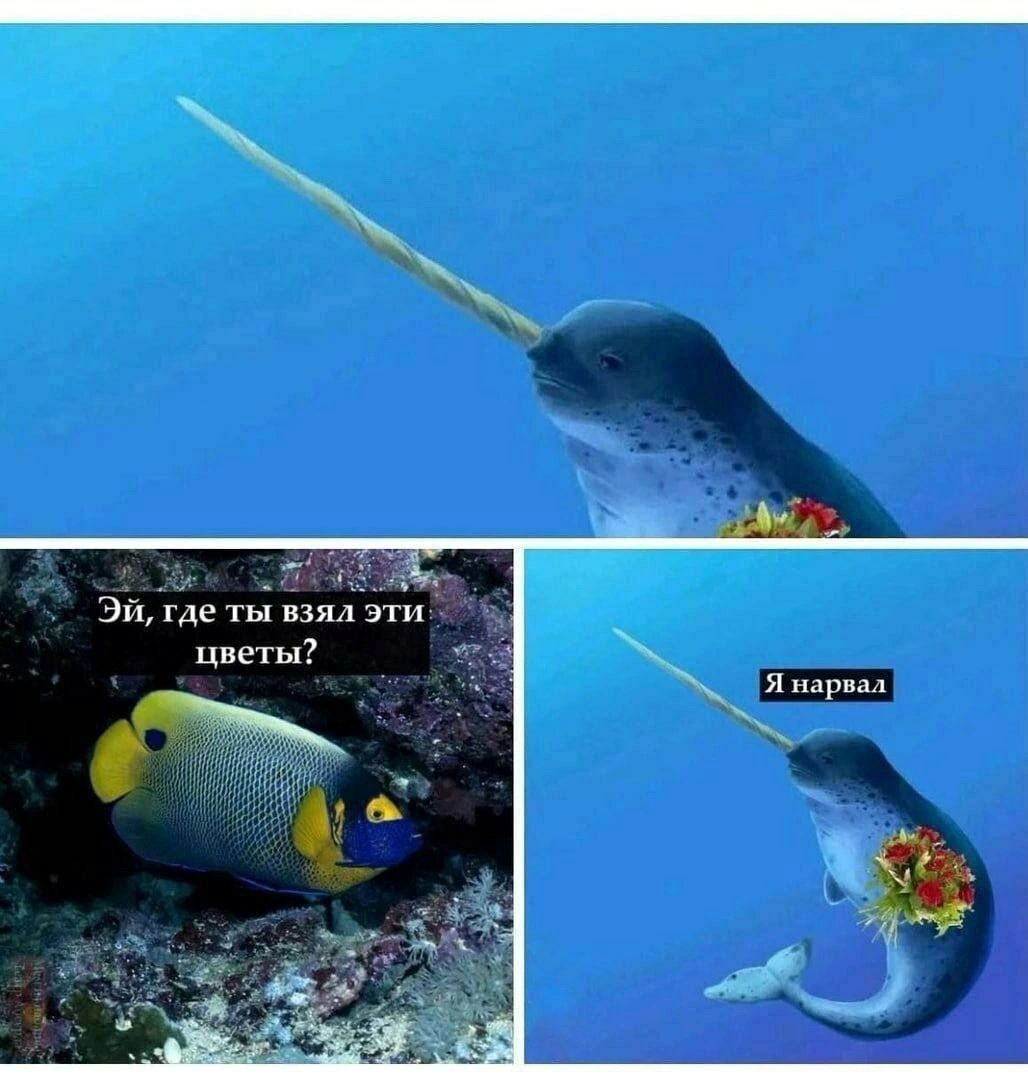

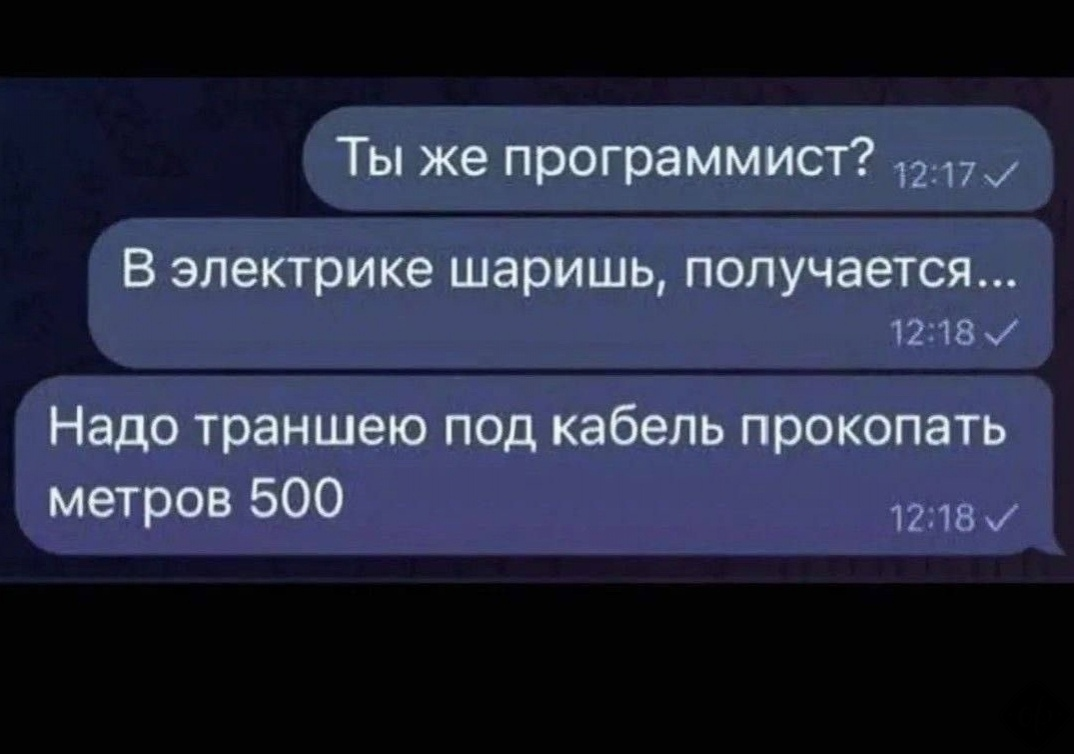